<a href="https://www.kaggle.com/code/davidmukajanga/package-delay?scriptVersionId=199003338" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Base plotting library
import seaborn as sns # Main plotting library
import geopandas as gpd
import folium # Mapping library
from IPython.display import display, IFrame # To display maps as cell outputs
from folium.plugins import MarkerCluster
from sklearn.model_selection import KFold # For dividing the dataset
from sklearn.preprocessing import StandardScaler # For scaling features
from sklearn.preprocessing import OneHotEncoder # For hot encoding data
from sklearn.preprocessing import LabelEncoder # For simpler data encoding
from sklearn.utils.class_weight import compute_class_weight # For dealing with different sizes of classification categories
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # For cross-validation evaluation
import tensorflow as tf # Base deeplearning modeller
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers # For deep learning modelling
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU # The hyper-parameters
from keras_tuner import HyperModel # For Hyper-parameter tuning
from keras_tuner.tuners import RandomSearch # Also for hyper-parameter tuning

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/logistics-data-containing-real-world-data/incom2024_delay_example_dataset.csv
/kaggle/input/logistics-data-containing-real-world-data/incom2024_delay_variable_description.csv


# Importing the Datasets

In [2]:
data = pd.read_csv("/kaggle/input/logistics-data-containing-real-world-data/incom2024_delay_example_dataset.csv")

data_description = pd.read_csv("/kaggle/input/logistics-data-containing-real-world-data/incom2024_delay_variable_description.csv")

display(data.head(), data_description)

data.head().to_csv("Data_sample.csv")
# data.to_csv("Data.csv")
# data_description.to_csv("Data_description.csv")

,payment_type,profit_per_order,sales_per_customer,category_id,category_name,customer_city,customer_country,customer_id,customer_segment,customer_state,...,order_region,order_state,order_status,product_card_id,product_category_id,product_name,product_price,shipping_date,shipping_mode,label
0,DEBIT,34.448338,92.49099,9.0,Cardio Equipment,Caguas,Puerto Rico,12097.6830,Consumer,PR,...,Western Europe,Vienna,COMPLETE,191.0,9.0,Nike Men's Free 5.0+ Running Shoe,99.99,2015-08-13 00:00:00+01:00,Standard Class,-1
1,TRANSFER,91.193540,181.99008,48.0,Water Sports,Albuquerque,EE. UU.,5108.1045,Consumer,CA,...,South America,Buenos Aires,PENDING,1073.0,48.0,Pelican Sunstream 100 Kayak,199.99,2017-04-09 00:00:00+01:00,Standard Class,-1
2,DEBIT,8.313806,89.96643,46.0,Indoor/Outdoor Games,Amarillo,Puerto Rico,4293.4478,Consumer,PR,...,Western Europe,Nord-Pas-de-Calais-Picardy,COMPLETE,1014.0,46.0,O'Brien Men's Neoprene Life Vest,49.98,2015-03-18 00:00:00+00:00,Second Class,1
3,TRANSFER,-89.463196,99.15065,17.0,Cleats,Caguas,Puerto Rico,546.5306,Consumer,PR,...,Central America,Santa Ana,PROCESSING,365.0,17.0,Perfect Fitness Perfect Rip Deck,59.99,2017-03-18 00:00:00+00:00,Second Class,0
4,DEBIT,44.722590,170.97824,48.0,Water Sports,Peabody,EE. UU.,1546.3980,Consumer,CA,...,Central America,Illinois,COMPLETE,1073.0,48.0,Pelican Sunstream 100 Kayak,199.99,2015-03-30 00:00:00+01:00,Standard Class,1


,variable_name,type,description
0,payment_type,categorical,Type of transaction made
1,profit_per_order,numerical,Earnings per order placed
2,sales_per_customer,numerical,Total sales per customer made per customer
3,category_id,numerical,Product category code
4,category_name,text,Description of the product category
5,customer_city,categorical,City where the customer made the purchase
6,customer_country,categorical,Country where the customer made the purchase
7,customer_id,numerical,Customer ID
8,customer_segment,categorical,"Types of Customers Consumer, Corporate, Home O..."
9,customer_state,categorical,State to which the store where the purchase is...


# Cleaning the data

In [3]:
# Mapping the "label" column with string categories instead of numerical ones

label_mapping = {
    -1: "Early Delivery",
     0: "On-time Delivery",
     1: "Delayed Delivery"
}

data["label"] = data["label"].map(label_mapping)

data.head()

,payment_type,profit_per_order,sales_per_customer,category_id,category_name,customer_city,customer_country,customer_id,customer_segment,customer_state,...,order_region,order_state,order_status,product_card_id,product_category_id,product_name,product_price,shipping_date,shipping_mode,label
0,DEBIT,34.448338,92.49099,9.0,Cardio Equipment,Caguas,Puerto Rico,12097.6830,Consumer,PR,...,Western Europe,Vienna,COMPLETE,191.0,9.0,Nike Men's Free 5.0+ Running Shoe,99.99,2015-08-13 00:00:00+01:00,Standard Class,Early Delivery
1,TRANSFER,91.193540,181.99008,48.0,Water Sports,Albuquerque,EE. UU.,5108.1045,Consumer,CA,...,South America,Buenos Aires,PENDING,1073.0,48.0,Pelican Sunstream 100 Kayak,199.99,2017-04-09 00:00:00+01:00,Standard Class,Early Delivery
2,DEBIT,8.313806,89.96643,46.0,Indoor/Outdoor Games,Amarillo,Puerto Rico,4293.4478,Consumer,PR,...,Western Europe,Nord-Pas-de-Calais-Picardy,COMPLETE,1014.0,46.0,O'Brien Men's Neoprene Life Vest,49.98,2015-03-18 00:00:00+00:00,Second Class,Delayed Delivery
3,TRANSFER,-89.463196,99.15065,17.0,Cleats,Caguas,Puerto Rico,546.5306,Consumer,PR,...,Central America,Santa Ana,PROCESSING,365.0,17.0,Perfect Fitness Perfect Rip Deck,59.99,2017-03-18 00:00:00+00:00,Second Class,On-time Delivery
4,DEBIT,44.722590,170.97824,48.0,Water Sports,Peabody,EE. UU.,1546.3980,Consumer,CA,...,Central America,Illinois,COMPLETE,1073.0,48.0,Pelican Sunstream 100 Kayak,199.99,2015-03-30 00:00:00+01:00,Standard Class,Delayed Delivery


# Exploratory Data Analysis

## Where are the sales coming from?

### Countries the orders are from

,customer_country,customer_segment,customer_city
0,Puerto Rico,Consumer,Caguas
1,EE. UU.,Consumer,Albuquerque
2,Puerto Rico,Consumer,Amarillo
3,Puerto Rico,Consumer,Caguas
4,EE. UU.,Consumer,Peabody


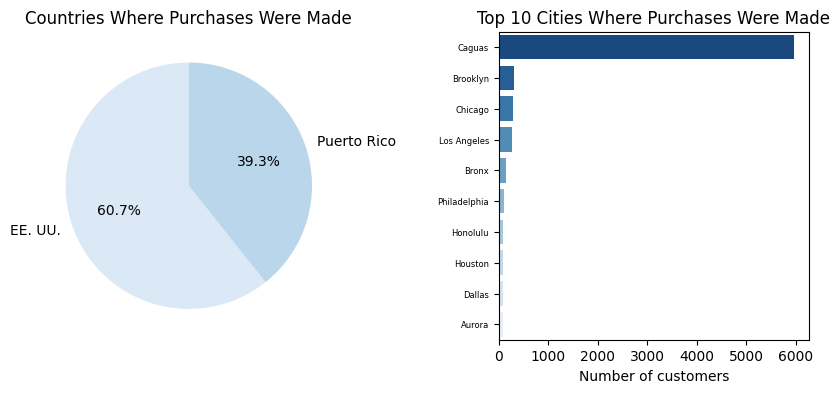

In [4]:
# Which countries are the orders coming from, and from which customers
countries_and_customers = data[["customer_country", "customer_segment", "customer_city"]] #.groupby(["customer_country"]).count()  # Creates a dataframe that displays all countries in the dataset and the number of times they appeared

display(countries_and_customers.head())


# Visualizing countries and cities
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

customers_by_countries = countries_and_customers.groupby("customer_country").count()

top_customer_cities = countries_and_customers.groupby("customer_city").count().sort_values("customer_segment", ascending=False).head(10) # There's no inherent meaning in choosing the customer_segment column as a sorting tool, any column would have been useful.

#display(customers_by_countries, customers_by_cities)

ax[0].pie(customers_by_countries["customer_city"], labels=customers_by_countries.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Blues'))
ax[0].set_title("Countries Where Purchases Were Made")

sns.barplot(
    data=top_customer_cities,
    x="customer_segment",
    y=top_customer_cities.index,
    ax=ax[1],
    palette="Blues_r"
).set(xlabel="Number of customers", ylabel="")

ax[1].set_title("Top 10 Cities Where Purchases Were Made")
ax[1].tick_params(axis="y", labelsize=6)

plt.subplots_adjust(wspace=0.5)
plt.savefig("Customer_countries_of_origin.png")
plt.show()

In [5]:
store_data = data[["department_name", 
          "longitude", 
          "latitude",
          "sales",
          "customer_country",
          "sales_per_customer",
          "customer_segment",
          "profit_per_order", 
          "category_name", 
          "order_item_discount",
          "order_item_discount_rate",
          "order_item_product_price",
          "order_item_quantity",
          "order_item_total_amount",
          "order_profit_per_order",
          "order_region",
          "order_city", 
          "order_country",
          "order_status",
          "product_name",
          "product_price",
          "shipping_mode",
          "label"
         ]]

#geometric_store_data.head(1)

#geometric_store_data.

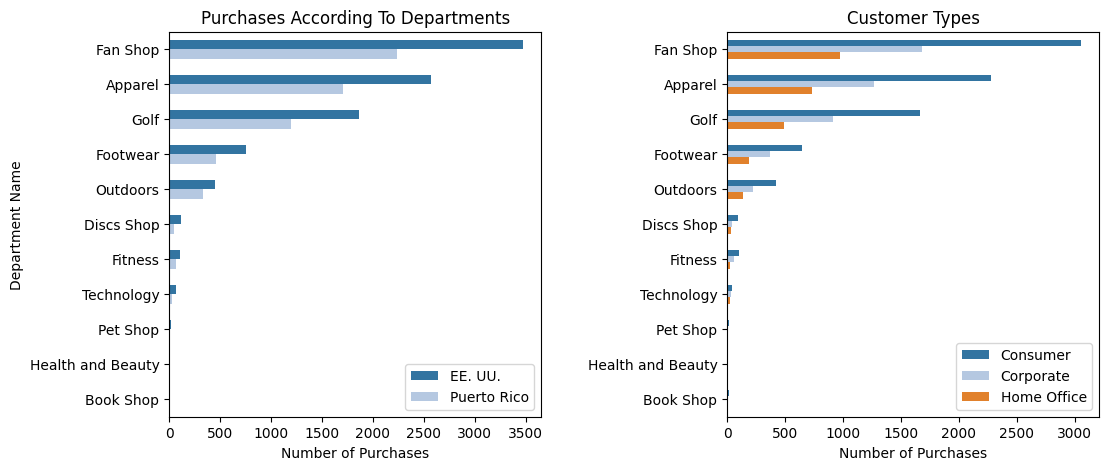

In [6]:
# Visualizing Store Locations according to number of purchases made
palette = sns.color_palette("dark:#5A9_r", as_cmap=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(
    data=store_data,
    y="department_name",
    hue="customer_country",
    order=["Fan Shop", "Apparel", "Golf", "Footwear", "Outdoors", "Discs Shop", "Fitness", "Technology", "Pet Shop", "Health and Beauty", "Book Shop"],
    hue_order=["EE. UU.", "Puerto Rico"],
    width=.55,
    palette="tab20",
    ax=ax[0]
).set(title="Purchases According To Departments", xlabel="Number of Purchases", ylabel="Department Name")

ax[0].legend(loc="lower right")


sns.countplot(
    data=store_data,
    y="department_name",
    hue="customer_segment",
    order=["Fan Shop", "Apparel", "Golf", "Footwear", "Outdoors", "Discs Shop", "Fitness", "Technology", "Pet Shop", "Health and Beauty", "Book Shop"],
#     hue_order=["EE. UU.", "Puerto Rico"],
    width=.55,
    palette="tab20",
    ax=ax[1]
).set(title="Customer Types", xlabel="Number of Purchases", ylabel="")

ax[1].legend(loc="lower right")

plt.subplots_adjust(wspace=0.5)
plt.savefig("Purchases_from_dpmnt.png")
plt.show()


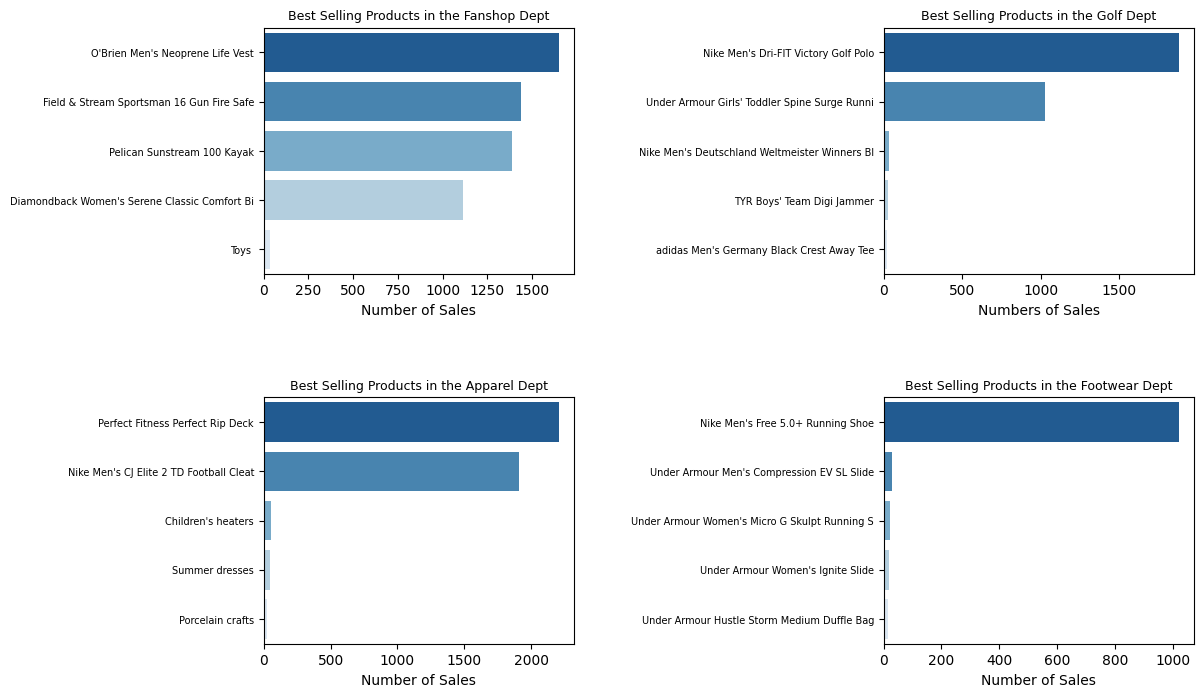

In [7]:
products_fan_shops = store_data[store_data["department_name"] == "Fan Shop"].groupby("product_name").count().sort_values("sales", ascending=False).head()

apparel_products = store_data[store_data["department_name"] == "Apparel"].groupby("product_name").count().sort_values("sales", ascending=False).head()

products_golf = store_data[store_data["department_name"] == "Golf"].groupby("product_name").count().sort_values("sales", ascending=False).head(5)

products_footwear = store_data[store_data["department_name"] == "Footwear"].groupby("product_name").count().sort_values("sales", ascending=False).head(5)


fig, ax = plt.subplots(2,2, figsize=(12, 8))

sns.barplot(
    data=products_fan_shops,
    y=products_fan_shops.index,
    x="sales",
    palette="Blues_r",
    ax=ax[0, 0]
).set(xlabel="Number of Sales", ylabel="")
ax[0, 0].tick_params(axis="y", labelsize=7)
ax[0, 0].set_title("Best Selling Products in the Fanshop Dept", fontsize=9)


sns.barplot(
    data=products_golf,
    y=products_golf.index,
    x="sales",
    palette="Blues_r",
    ax=ax[0, 1]
).set(xlabel="Numbers of Sales", ylabel="")
ax[0, 1].tick_params(axis="y", labelsize=7)
ax[0, 1].set_title("Best Selling Products in the Golf Dept", fontsize=9)

sns.barplot(
    data=apparel_products,
    y=apparel_products.index,
    x="sales",
    palette="Blues_r",
    ax=ax[1, 0]
).set(xlabel="Number of Sales", ylabel="")
ax[1, 0].tick_params(axis="y", labelsize=7)
ax[1, 0].set_title("Best Selling Products in the Apparel Dept", fontsize=9)

sns.barplot(
    data=products_footwear,
    y=products_footwear.index,
    x="sales",
    palette="Blues_r",
    ax=ax[1, 1]
).set(xlabel="Number of Sales", ylabel="")
ax[1, 1].tick_params(axis="y", labelsize=7)
ax[1, 1].set_title("Best Selling Products in the Footwear Dept", fontsize=9)


plt.subplots_adjust(wspace=1, hspace=0.5)
plt.savefig("best_selling_products_each_dept.png")
plt.show()

## Which products sell the most.

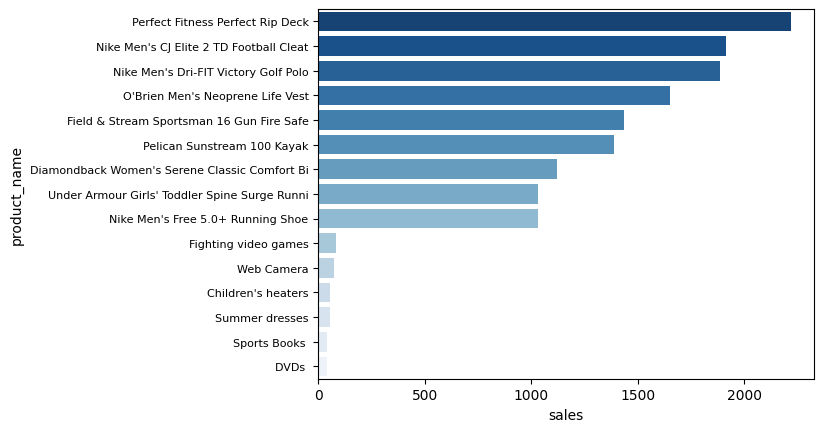

In [8]:
best_selling_products = store_data.groupby("product_name").count().sort_values("longitude", ascending=False) # The choice of which column to sort the data on was arbitrary. It doesn't hold any meaning.

sns.barplot(
    data=best_selling_products.head(15),
    y=best_selling_products.head(15).index,
    x="sales",
    palette="Blues_r"
)
plt.tick_params(axis="y", labelsize=8)
plt.savefig("best_selling_products.png")

## Where do the products go to?

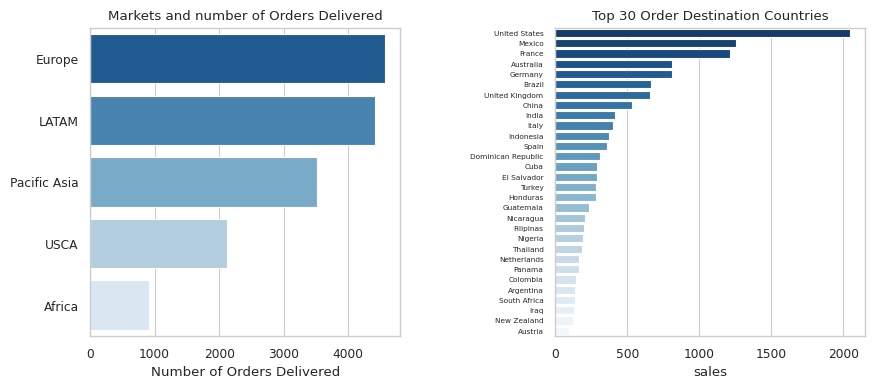

In [9]:
# Which markets are the orders delivered to?
markets = data[["market", "customer_segment"]]
order_countries = data.groupby("order_country").count().sort_values("label", ascending=False) # The sorting column was arbitrary.
markets_grouped = markets.groupby(["market"]).count().sort_values('customer_segment', ascending=False)
#display(markets_grouped)


# Visualizing the size and customers from each market
sns.set_style("whitegrid")
sns.set_context("paper")

## Instantiating the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(
    data=markets_grouped,
    x="customer_segment",
    y=markets_grouped.index,
    palette="Blues_r",
    ax=ax[0]
).set(xlabel="Number of Orders Delivered", title="Markets and number of Orders Delivered", ylabel="")


sns.barplot(
    data=order_countries.head(30),
    y=order_countries.head(30).index,
    x="sales",
    palette="Blues_r",
    ax=ax[1]
).set(title="Top 30 Order Destination Countries", ylabel="")

ax[1].tick_params(axis="y", labelsize=5.3)

plt.subplots_adjust(wspace=0.5)
plt.savefig("order_destinations.png")
plt.show()

## Tracing delays

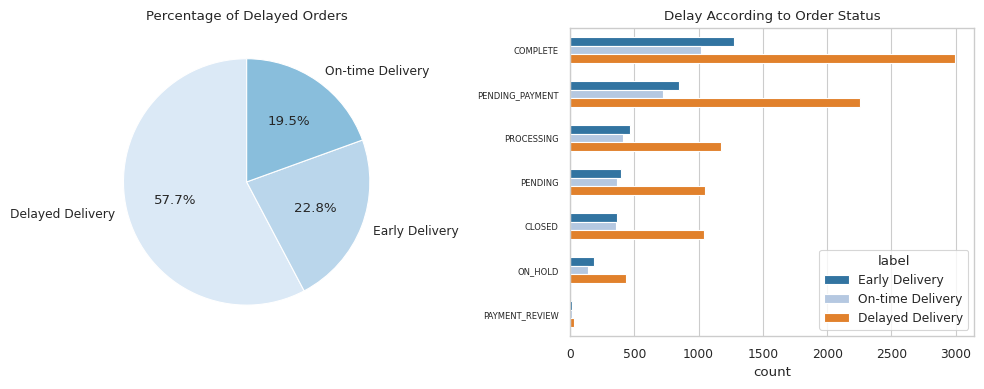

In [10]:
# Percent of Delayed orders 
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].pie(data.groupby("label").count().sort_values("sales", ascending=False)["sales"], labels=data.groupby("label").count().sort_values("sales", ascending=False).index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Blues'))
ax[0].set_title("Percentage of Delayed Orders")

sns.countplot(
    data=data,
    y="order_status",
    hue="label",
    palette="tab20",
    ax=ax[1],
    order=["COMPLETE", "PENDING_PAYMENT", "PROCESSING", "PENDING", "CLOSED", "ON_HOLD", "PAYMENT_REVIEW"],
    hue_order=["Early Delivery", "On-time Delivery", "Delayed Delivery"],
    width=.6
).set(ylabel="", title="Delay According to Order Status")
ax[1].tick_params(axis="y", labelsize=6)

plt.subplots_adjust(wspace=0.3)
plt.savefig("percentage_of_delayed_orders.png")
plt.show()

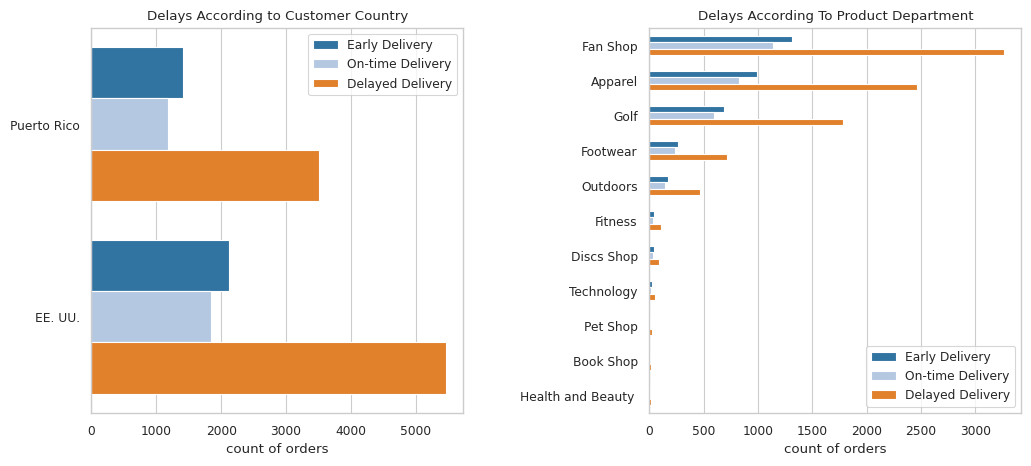

In [11]:
# Delayed orders vs Purchase coutries and regions
purchases_from_departments = data.groupby("department_name").count().sort_values("label", ascending=False).index

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(
    data=data,
    y="department_name",
    hue="label",
    order=purchases_from_departments,
    palette="tab20",
    ax=ax[1],
    hue_order=["Early Delivery", "On-time Delivery", "Delayed Delivery"],
    width=0.55
).set(title="Delays According To Product Department", ylabel="", xlabel="count of orders")

ax[1].legend(loc="lower right")

sns.countplot(
    data=data,
    y="customer_country",
    hue="label",
    palette="tab20",
    ax=ax[0],
    hue_order=["Early Delivery", "On-time Delivery", "Delayed Delivery"],
    width=0.8
).set(title="Delays According to Customer Country", ylabel="", xlabel="count of orders")

ax[0].legend(loc="upper right")

plt.subplots_adjust(wspace=0.5)
plt.savefig("delays_vs_customer_country_and_prod_dptment.png")
plt.show()

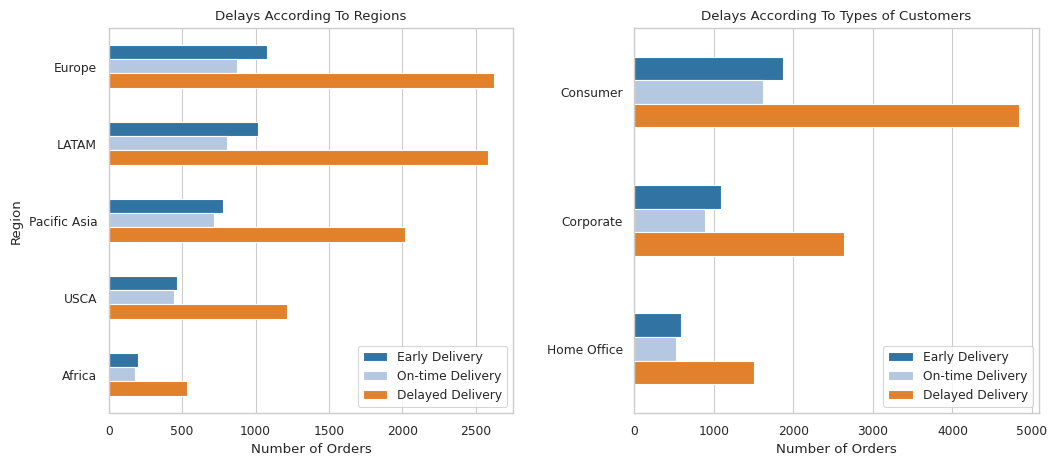

In [12]:
# Delays According to customer and payment types

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(
    data=data,
    y="market",
    hue="label",
    order=["Europe", "LATAM", "Pacific Asia", "USCA", "Africa"],
    hue_order=["Early Delivery", "On-time Delivery", "Delayed Delivery"],
    width=.55,
    palette="tab20",
    ax=ax[0]
).set(title="Delays According To Regions", xlabel="Number of Orders", ylabel="Region")

ax[0].legend(loc="lower right")


sns.countplot(
    data=data,
    y="customer_segment",
    hue="label",
#     order=["DEBIT", "PAYMENT", "TRANSFER", "CASH"],
    hue_order=["Early Delivery", "On-time Delivery", "Delayed Delivery"],
    width=.55,
    palette="tab20",
    ax=ax[1]
).set(title="Delays According To Types of Customers", xlabel="Number of Orders", ylabel="")

ax[1].legend(loc="lower right")

plt.subplots_adjust(wspace=0.3)
plt.savefig("delays_according_to_regions_and_customers.png")
plt.show()

In [13]:
count_delayed_orders = data.shape[0] * 0.577

count_delayed_orders

8971.773

In [14]:
# Dropping rows with "NaT" values in order_date and shipping_date column
data = data.dropna(subset=["order_date", "shipping_date"])


# Calculating Shipping delays
# Convert order_date and shipping_date to datetime objects
data['order_date'] = pd.to_datetime(data['order_date'], errors="coerce", utc=True)
data['shipping_date'] = pd.to_datetime(data['shipping_date'], errors="coerce", utc=True)

clean_data = data.dropna(subset=["order_date", "shipping_date"]) # To prevent the error that would otherwise happen in the next step

# Calculate the delay as the difference between shipping and order dates
clean_data.loc[:, ['delay_days']] = (clean_data['shipping_date'] - clean_data['order_date']).dt.days

# Filter rows where delay_days is greater than a threshold
delayed_orders = clean_data[
    (clean_data['delay_days'] > 7) & 
    (clean_data["label"] == "Delayed Delivery") & 
    (clean_data["order_status"] != "PENDING_PAYMENT") & 
    (clean_data["order_status"] != "PENDING")
]

sample = delayed_orders[["delay_days", "product_name", "order_status", "order_country", "order_region", "label"]]

count_treatable_delays = sample.shape[0]

display(count_treatable_delays)

percent_treatable_delays = (sample.shape[0] / data.shape[0]) * 100

display(percent_treatable_delays)

sample

3113

20.020580101614254

,delay_days,product_name,order_status,order_country,order_region,label
2,76,O'Brien Men's Neoprene Life Vest,COMPLETE,France,Western Europe,Delayed Delivery
5,130,Under Armour Women's Ignite PIP VI Slide,CLOSED,United States,East of USA,Delayed Delivery
6,47,O'Brien Men's Neoprene Life Vest,COMPLETE,United States,West of USA,Delayed Delivery
8,200,Nike Men's CJ Elite 2 TD Football Cleat,ON_HOLD,Thailand,Southeast Asia,Delayed Delivery
13,75,Pelican Sunstream 100 Kayak,CLOSED,Nigeria,West Africa,Delayed Delivery
...,...,...,...,...,...,...
15533,48,Nike Men's Comfort 2 Slide,COMPLETE,France,Western Europe,Delayed Delivery
15537,36,Nike Men's Free 5.0+ Running Shoe,COMPLETE,Mexico,Central America,Delayed Delivery
15540,64,Nike Men's Dri-FIT Victory Golf Polo,COMPLETE,Australia,Oceania,Delayed Delivery
15542,64,Nike Men's Dri-FIT Victory Golf Polo,PROCESSING,Mexico,Central America,Delayed Delivery


In [15]:
# Group delays by regions, cities, or countries
delay_by_region = delayed_orders.groupby('order_region')['delay_days'].median().sort_values(ascending=False)
delay_by_country = delayed_orders.groupby('order_country')['delay_days'].median().sort_values(ascending=False)

# display(delay_by_region)
# display(delay_by_country)


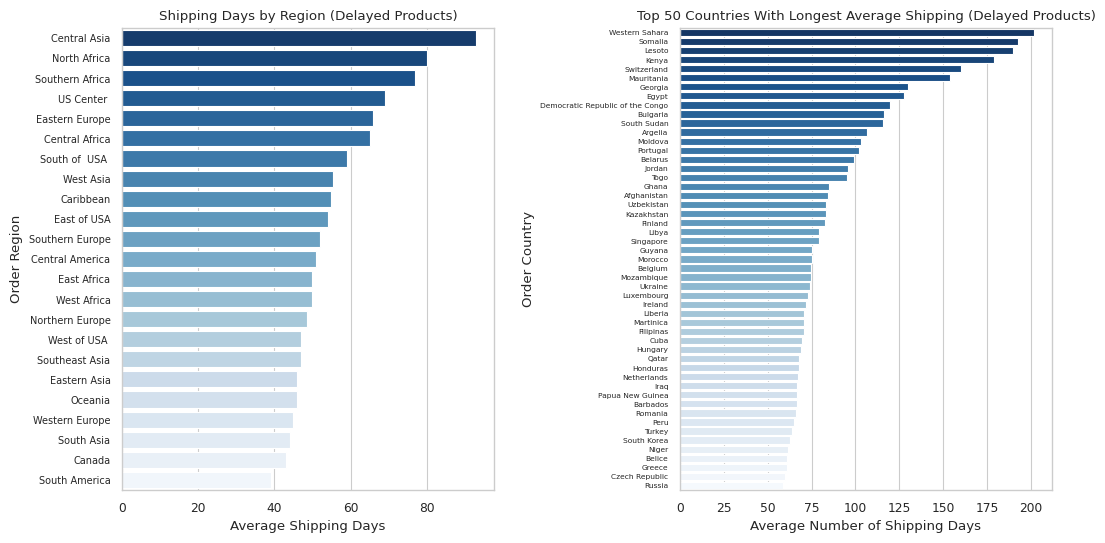

In [16]:
# Average shipping day for delayed products
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(
    y=delay_by_region.index, 
    x=delay_by_region.values, 
    palette="Blues_r",
    ax=ax[0]
).set(ylabel="Order Region")
ax[0].tick_params(axis="y", labelsize=7)
ax[0].set_title("Shipping Days by Region (Delayed Products)")
ax[0].set_xlabel("Average Shipping Days")

sns.barplot(
    y=delay_by_country[:51].index, 
    x=delay_by_country[:51].values, 
    palette="Blues_r",
    ax=ax[1]
).set(ylabel="Order Country", 
      xlabel="Average Number of Shipping Days", 
      title="Top 50 Countries With Longest Average Shipping (Delayed Products)"
     )

ax[1].tick_params(axis="y", labelsize=5.4)
plt.subplots_adjust(wspace=0.5)
plt.savefig("shipping_days_by_region.png")
plt.show()

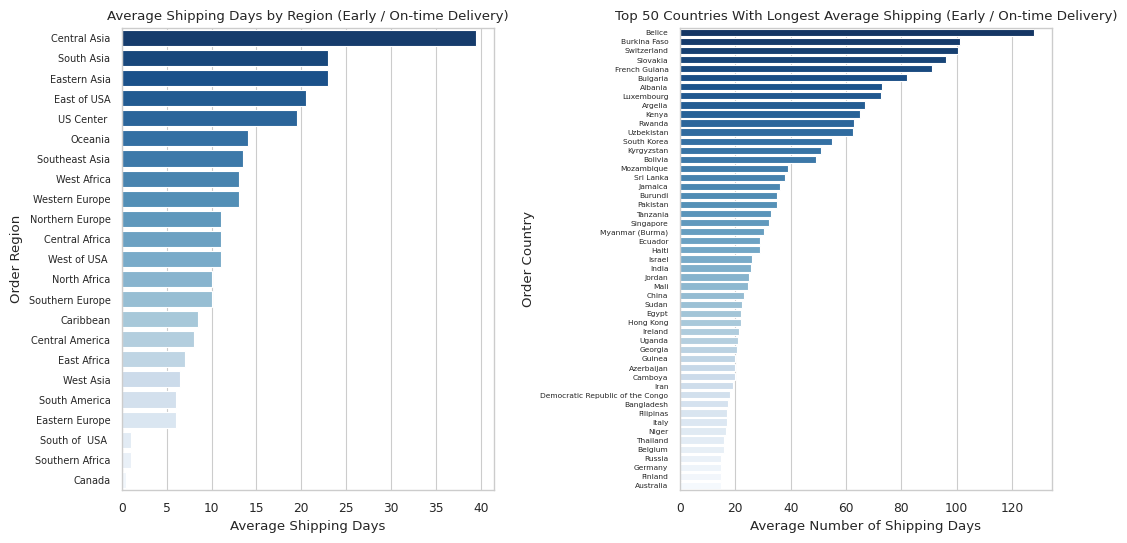

In [17]:
# Average Shipping days overall
shipping_by_region = clean_data[clean_data["label"] != "Delayed Delivery"].groupby('order_region')['delay_days'].median().sort_values(ascending=False)
shipping_by_country = clean_data[clean_data["label"] != "Delayed Delivery"].groupby('order_country')['delay_days'].median().sort_values(ascending=False)

shipping_by_region
shipping_by_country[:51]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(
    y=shipping_by_region.index, 
    x=shipping_by_region.values, 
    palette="Blues_r",
    ax=ax[0]
).set(ylabel="Order Region")
ax[0].tick_params(axis="y", labelsize=7)
ax[0].set_title("Average Shipping Days by Region (Early / On-time Delivery)")
ax[0].set_xlabel("Average Shipping Days")

sns.barplot(
    y=shipping_by_country[:51].index, 
    x=shipping_by_country[:51].values, 
    palette="Blues_r",
    ax=ax[1]
).set(ylabel="Order Country", 
      xlabel="Average Number of Shipping Days", 
      title="Top 50 Countries With Longest Average Shipping (Early / On-time Delivery)"
     )

ax[1].tick_params(axis="y", labelsize=5.4)
plt.subplots_adjust(wspace=0.5)
plt.savefig("shipping_days_by_region.png")
plt.show()

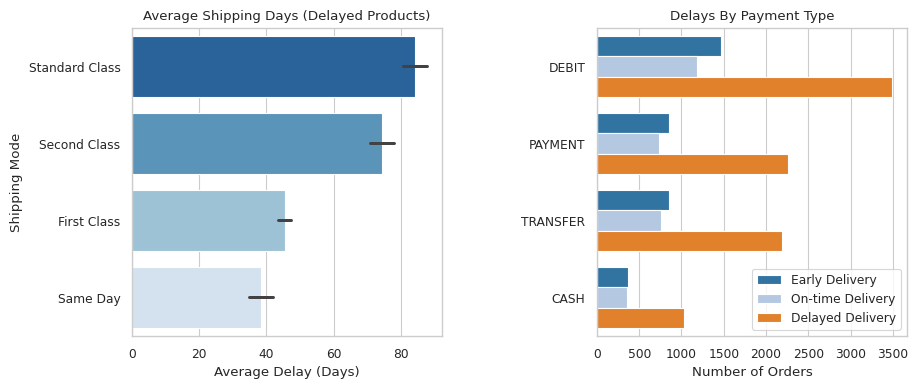

In [18]:
# Delays by shipping mode and payment
delay_by_shipping_mode = delayed_orders.groupby('shipping_mode')['delay_days'].mean()
payment_and_delays = data[["payment_type", "label"]]
order = ["DEBIT", "PAYMENT", "TRANSFER", "CASH"]
hue_order = ["Early Delivery", "On-time Delivery", "Delayed Delivery"]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(
    data=delayed_orders,
    y="shipping_mode", 
    x="delay_days", 
    order=["Standard Class", "Second Class", "First Class", "Same Day"],
    palette="Blues_r",
    ax=ax[0]
).set(ylabel="Shipping Mode")
ax[0].set_title("Average Shipping Days (Delayed Products)")
ax[0].set_xlabel("Average Delay (Days)")

sns.countplot(
    data=payment_and_delays,
    y="payment_type",
    hue="label",
    order=order,
    hue_order=hue_order,
    ax=ax[1],
    palette="tab20"
).set(xlabel="Number of Orders", title="Delays By Payment Type", ylabel="")

ax[1].legend(loc="lower right")

plt.subplots_adjust(wspace=0.5)
plt.savefig("Delays_by_shipping_mode_and_payment_type.png")
plt.show()

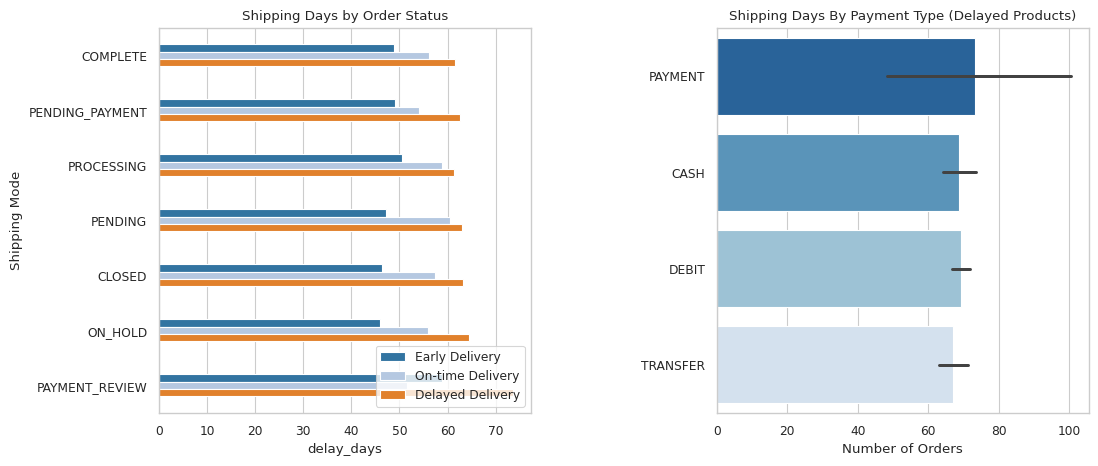

In [19]:
# Shipping days according to order status and payment_type
sorted_order_status = clean_data.groupby("order_status").count().sort_values("label", ascending=False).index # The sorting column is arbitrary. There was no meaning behind selecting it.

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(
    data=delayed_orders,
    y="payment_type",
    x="delay_days",
    order=["PAYMENT", "CASH", "DEBIT", "TRANSFER"],
#     hue_order=hue_order,
    ax=ax[1],
    palette="Blues_r"
).set(xlabel="Number of Orders", title="Shipping Days By Payment Type (Delayed Products)", ylabel="")

sns.barplot(
    data=clean_data[clean_data["delay_days"] > 0],
    y="order_status", 
    x="delay_days", 
    order=sorted_order_status,
    palette="tab20",
    ax=ax[0],
    hue="label",
    hue_order=["Early Delivery", "On-time Delivery", "Delayed Delivery"],
    width=.4,
    errorbar=None
).set(ylabel="Shipping Mode", title="Shipping Days by Order Status")

ax[0].legend(loc="lower right", bbox_to_anchor=(1, 0))

plt.subplots_adjust(wspace=0.5)
plt.savefig("shipping_days_by_order_status_and_payment_type.png")
# plt.set_title("Average Shipping Days (Delayed Products)")
# plt.set_xlabel("Average Delay (Days)")

# Modelling Delays

In [20]:
delayed_orders.columns # Display the columns so that you can see which columns might be of interest

Index(['payment_type', 'profit_per_order', 'sales_per_customer', 'category_id',
       'category_name', 'customer_city', 'customer_country', 'customer_id',
       'customer_segment', 'customer_state', 'customer_zipcode',
       'department_id', 'department_name', 'latitude', 'longitude', 'market',
       'order_city', 'order_country', 'order_customer_id', 'order_date',
       'order_id', 'order_item_cardprod_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_id', 'order_item_product_price',
       'order_item_profit_ratio', 'order_item_quantity', 'sales',
       'order_item_total_amount', 'order_profit_per_order', 'order_region',
       'order_state', 'order_status', 'product_card_id', 'product_category_id',
       'product_name', 'product_price', 'shipping_date', 'shipping_mode',
       'label', 'delay_days'],
      dtype='object')

In [21]:
# Drop missing values and unwanted columns
data = clean_data.dropna(axis=1, how="any")[["order_country", "order_region", "order_status", "shipping_mode", "payment_type", "label", "department_name"]]

data.head()

,order_country,order_region,order_status,shipping_mode,payment_type,label,department_name
0,Austria,Western Europe,COMPLETE,Standard Class,DEBIT,Early Delivery,Footwear
1,Argentina,South America,PENDING,Standard Class,TRANSFER,Early Delivery,Fan Shop
2,France,Western Europe,COMPLETE,Second Class,DEBIT,Delayed Delivery,Fan Shop
3,El Salvador,Central America,PROCESSING,Second Class,TRANSFER,On-time Delivery,Apparel
4,Mexico,Central America,COMPLETE,Standard Class,DEBIT,Delayed Delivery,Fan Shop


In [22]:
# Separate features (X) and target variable (y)
X = data.drop(columns=['label'])
y = data['label']

# Handle categorical variables by encoding them
onehot = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = onehot.fit_transform(X.select_dtypes(include=['object']))
X_numeric = X.select_dtypes(exclude=['object'])

# Combine numerical features with one-hot encoded categorical features
X = np.hstack((X_numeric, X_encoded))


# Encoding y explicitly
le_label = LabelEncoder()
y = le_label.fit_transform(y)

# Computing class weights from the classification column
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

## Changing the weights to a dictionary to be able to be fed to the model
class_weights = {i: class_weights[i] for i in range(len(class_weights))} 
display(class_weights)

# Normalize the numerical features (optional but recommended for neural networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Creating KFolds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

{0: 0.5774286987522281, 1: 1.4620592383638928, 2: 1.7116908850726553}

In [23]:
# Lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []




# Loop over each fold
for train_index, val_index in kf.split(X_scaled):
    # Split the data into training and validation sets for this fold
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    
    # Defining the model
    model = Sequential([
    Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(384, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Multiclass Classification
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=0, class_weight=class_weights)
    
    # Predict on the validation set
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average="weighted")
    recall = recall_score(y_val, y_pred, average="weighted")
    f1 = f1_score(y_val, y_pred, average="weighted")
    
    # Store the metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)


# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Display the results
print(f"Average Accuracy: {avg_accuracy * 100:.2f}%")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Average Accuracy: 50.00%
Average Precision: 0.6538
Average Recall: 0.5000
Average F1-Score: 0.4939


In [24]:
# Lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []


# Define a function that builds the model with hyperparameters
def create_model(hp):
    model = tf.keras.Sequential()
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu', input_shape=(X_train.shape[1],)))
    
    # Tune dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout))
    
    # Tune number of hidden layers
    for i in range(hp.Int('num_layers', 1, 8)):  # Between 1 to 4 hidden layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(3, activation='softmax'))  # multiclass classification
    
    # Tune the learning rate
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


# Define the tuner
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=5,  # Number of different models to try
    executions_per_trial=3,  # Number of times to train each model for robustness
    directory='my_dir',  # Directory to save logs and results
    project_name='tuning_delay_prediction'
)


# Loop over each fold
for train_index, val_index in kf.split(X_scaled):
    # Split the data into training and validation sets for this fold
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Perform the hyper-parameter search
    tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

    # Retrieve the best model and hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Print the best hyper-parameters
    print(f"The optimal number of units in the first hidden layer is {best_hps.get('units')}")
    print(f"The optimal learning rate is {best_hps.get('learning_rate')}")
    
    # Build and train the model using the best hyper-parameters
    model = tuner.hypermodel.build(best_hps)
    model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),  verbose=0, class_weight=class_weights)
    
#     model = create_model()
#     history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=0, class_weight=class_weights)
    
    # Predict on the validation set
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)


    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average="weighted")
    recall = recall_score(y_val, y_pred, average="weighted")
    f1 = f1_score(y_val, y_pred, average="weighted")
    
    # Store the metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Display the results
print(f"Average Accuracy: {avg_accuracy * 100:.2f}%")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")

Trial 5 Complete [00h 02m 03s]
val_accuracy: 0.5766345262527466

Best val_accuracy So Far: 0.5780278841654459
Total elapsed time: 00h 09m 44s
The optimal number of units in the first hidden layer is 512
The optimal learning rate is 0.0006761751314520794
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The optimal number of units in the first hidden layer is 512
The optimal learning rate is 0.0006761751314520794


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The optimal number of units in the first hidden layer is 512
The optimal learning rate is 0.0006761751314520794


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The optimal number of units in the first hidden layer is 512
The optimal learning rate is 0.0006761751314520794


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The optimal number of units in the first hidden layer is 512
The optimal learning rate is 0.0006761751314520794


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Average Accuracy: 49.72%
Average Precision: 0.6278
Average Recall: 0.4972
Average F1-Score: 0.5092
